# Ocean transports and maps

Transports in the climate system are often represented as gridded vector fields (e.g. on a `C-grid`) and integrated across `grid edge paths` that e.g. (1) connect location pairs or (2) tracks latitude circles. For more detail, please refer to [Forget et al, 2015](https://doi.org/10.5194/gmd-8-3071-2015) (incl. appendices)

### Read grid & transports from file

1. pre-requisites
2. read variables

In [1]:
using MeshArrays, Plots, Statistics, MITgcmTools

include("prepare_transports.jl")
p=dirname(pathof(MeshArrays))
include(joinpath(p,"../examples/Plots.jl"))

if !isdir("../inputs/GRID_LLC90")
    run(`git clone https://github.com/gaelforget/GRID_LLC90 ../inputs/GRID_LLC90`)
end

In [2]:
mypath="../inputs/GRID_LLC90/"
mygrid=GridSpec("LatLonCap",mypath)
GridVariables=GridLoad(mygrid)
(TrspX, TrspY, TauX, TauY, SSH)=trsp_read(mygrid,mypath);

### Integrate transport across latitude lines

1. `LatitudeCircles` computes `grid edge path`s that track latitude circles
2. `ThroughFlow` integrates transports accross the specified `grid edge path`s

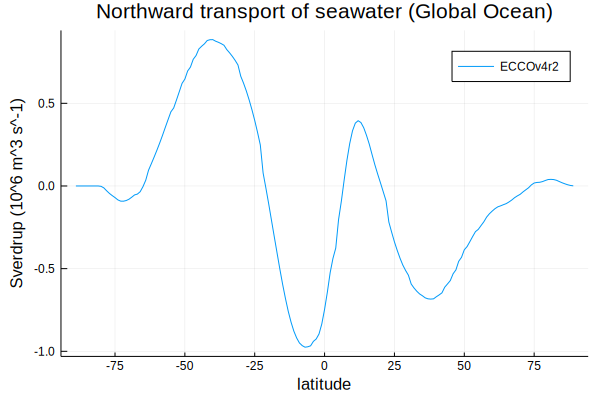

In [3]:
UVmean=Dict("U"=>TrspX,"V"=>TrspY,"dimensions"=>["x","y"])
l=-89.0:89.0; LC=LatitudeCircles(l,GridVariables)
T=Array{Float64,1}(undef,length(LC))
for i=1:length(LC)
   T[i]=ThroughFlow(UVmean,LC[i],GridVariables)
end

plot(l,T/1e6,xlabel="latitude",ylabel="Sverdrup (10^6 m^3 s^-1)",
    label="ECCOv4r2",title="Northward transport of seawater (Global Ocean)")

## Post-Process Result For Plotting

1. Convert to `Sv` units and mask out land
2. Interpolate `x/y` transport to grid cell center
3. Convert to `Eastward/Northward` transport

In [4]:
u=1e-6 .*UVmean["U"]; v=1e-6 .*UVmean["V"];
u[findall(GridVariables["hFacW"][:,1].==0)].=NaN
v[findall(GridVariables["hFacS"][:,1].==0)].=NaN;

In [5]:
using Statistics
nanmean(x) = mean(filter(!isnan,x))
nanmean(x,y) = mapslices(nanmean,x,dims=y)
(u,v)=exch_UV(u,v); uC=similar(u); vC=similar(v)
for iF=1:mygrid.nFaces
    tmp1=u[iF][1:end-1,:]; tmp2=u[iF][2:end,:]
    uC[iF]=reshape(nanmean([tmp1[:] tmp2[:]],2),size(tmp1))
    tmp1=v[iF][:,1:end-1]; tmp2=v[iF][:,2:end]
    vC[iF]=reshape(nanmean([tmp1[:] tmp2[:]],2),size(tmp1))
end

In [6]:
cs=GridVariables["AngleCS"]
sn=GridVariables["AngleSN"]
u=uC.*cs-vC.*sn
v=uC.*sn+vC.*cs;

### Plot transport arrays

1. `uC,vC` are oriented along the `x,y` directions of each subdomain
2. `u,v` are oriented in the `Eastward,Northward` directions

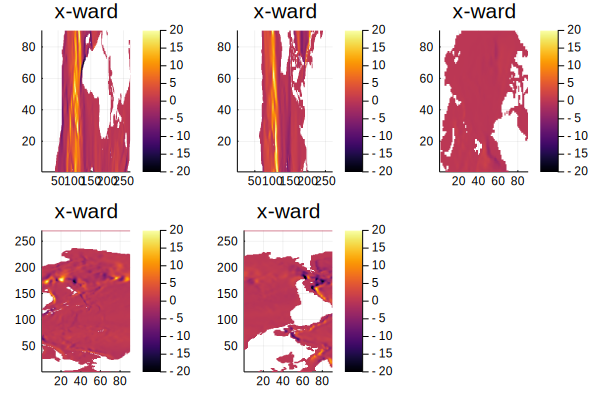

In [7]:
heatmap(uC,clims=(-20.0,20.0),title="x-ward")
#heatmap(vC,clims=(-20.0,20.0),title="y-ward")

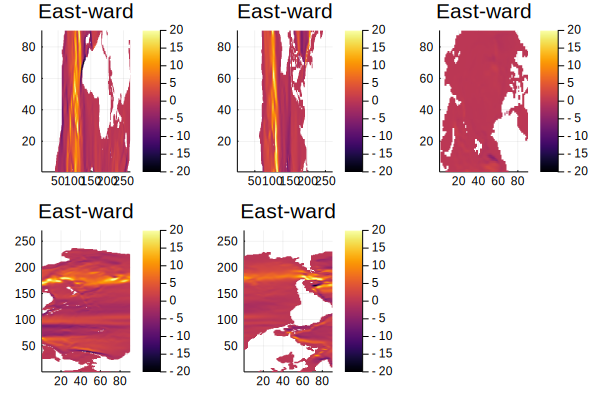

In [8]:
heatmap(u,clims=(-20.0,20.0),title="East-ward")
#heatmap(v,clims=(-20.0,20.0),title="North-ward")

### Map out transport 

1. interpolate `u,v` to a `1/2 x 1/2` degree grid for plotting
2. plot e.g. the Eastward transport component as a global map

In [9]:
mypath="../inputs/GRID_LLC90/"
SPM,lon,lat=read_SPM(mypath) #interpolation matrix (sparse)
uI=MatrixInterp(write(u),SPM,size(lon)) #interpolation itself
vI=MatrixInterp(write(v),SPM,size(lon)); #interpolation itself

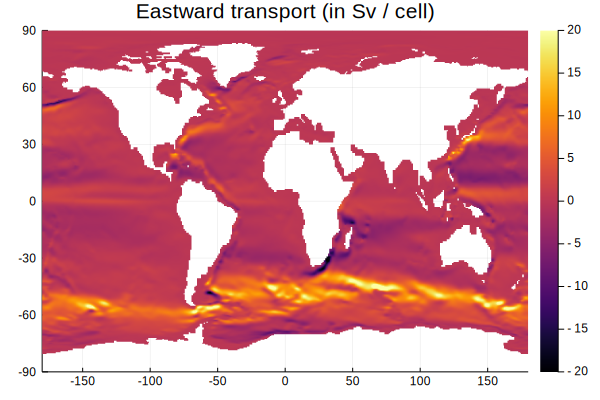

In [10]:
heatmap(vec(lon[:,1]),vec(lat[1,:]),transpose(uI),clims=(-20.0,20.0),title="Eastward transport (in Sv / cell)")
#heatmap(vec(lon[:,1]),vec(lat[1,:]),transpose(vI),clims=(-20.0,20.0),title="Northward transport (in Sv / cell)")